# Alternative Models: Lazy Learners

<hr>

* k-Nearest Neighbors (kNN)
* Radius Neighbors Classifier (RNC)

In [1]:
# Import needed libraries and modules
from codecarbon import EmissionsTracker
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline
import json


# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [2]:
# ---------------------------------------------------------------------------- #
#                                PRE-PROCESSING                                #
# ---------------------------------------------------------------------------- #

##### SETTINGS #####
PC_Features = True
Random_Seed = 82024
K_Folds = 10
Max_Iterations = 200
####################

# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize target
df.loc[df['num'] != 0, 'num'] = 1

# Define features and target vectors
X = df.iloc[:,:-1]
y = df['num']

# Separate integer from categorical features
int_features, cat_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],\
['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('int', StandardScaler(), int_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

<hr>

## k-Nearest Neighbors (k-NN)

k-NN is an instance-based learning algorithm that classifies data points based on the majority class of their k-nearest neighbors. It is a simple yet effective method that leverages the similarity between data points.

k-NN is interesting for this dataset because it directly uses the data distribution to classify new samples, making it highly adaptable without requiring complex training. However, k-NN can be sensitive to noisy data and irrelevant features, and performance can degrade with imbalanced classes or high-dimensional data. For the latter reason, it is expected to perform better after applying dimensionality reduction to the dataset.

In [3]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Initiate CodeCarbon to track emissions
tracker = EmissionsTracker('k-NN model', log_level='warning')
tracker.start()

# Create model
model = KNeighborsClassifier(n_neighbors=3)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('k-NN-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('k-NN-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], cv=K_Folds)

# Calculate and display results
acc = np.mean(cv_results['test_accuracy'])
acc_std = np.std(cv_results['test_accuracy'])
roc_auc = np.mean(cv_results['test_roc_auc'])
roc_auc_std = np.std(cv_results['test_roc_auc'])

print(f"Accuracy: {acc:.4f} ± {acc_std:.4f}")
print(f"AUC-ROC: {roc_auc:.4f} ± {roc_auc_std:.4f}")

# Stop emission tracking
_ = tracker.stop()

[codecarbon ERROR @ 10:25:05] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.
[codecarbon WARNING @ 10:25:05] Another instance of codecarbon is already running. Exiting.


[codecarbon WARNING @ 10:25:05] Another instance of codecarbon is already running. Exiting.


Accuracy: 0.8048 ± 0.0719
AUC-ROC: 0.8550 ± 0.0626


In [4]:
# Save evaluation to an external file
file = 'scores.csv'

results = pd.DataFrame({
    'k-NN-model': [acc, acc_std, roc_auc, roc_auc_std]
}, index = ['Accuracy', 'Accuracy STD', 'AUC-ROC', 'AUC-ROC STD'])

# Check if file exists
if os.path.exists(file):
    temp = pd.read_csv(file, index_col=0)
    results = pd.concat([temp, results], axis=1)

# Export
results.to_csv(file)

[codecarbon ERROR @ 10:25:06] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.
[codecarbon WARNING @ 10:25:06] Another instance of codecarbon is already running. Exiting.


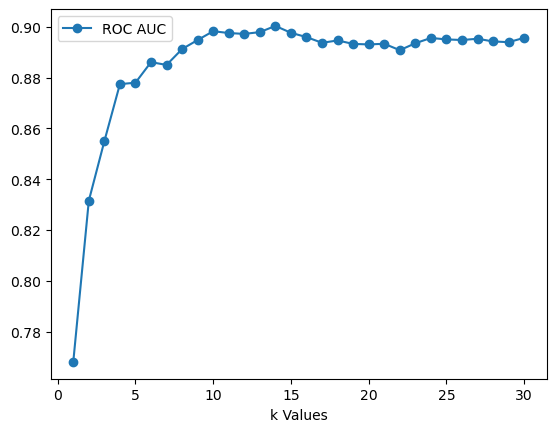

Best k value: 14


In [5]:
# ---------------------------------------------------------------------------- #
#                                 OPTIMIZATION                                 #
# ---------------------------------------------------------------------------- #

# Initiate CodeCarbon to track emissions# Initiate CodeCarbon to track emissions
tracker = EmissionsTracker('k-NN optimization', log_level='warning')
tracker.start()

# Optimize k values (cross validation)
k_vals = [i for i in range(1,31)]
roc_aucs = []

for k in k_vals:
    # Create model
    temp_model = KNeighborsClassifier(n_neighbors=k)
    
    # Define pipeline depending on whether PCA is requested or not
    if PC_Features:
        steps = [
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=12)),
            ('k-NN-classifier', temp_model)
        ]
    else:
        steps = [
            ('preprocessor', preprocessor),
            ('k-NN-classifier', temp_model)
        ]
        
    pipeline = Pipeline(steps)
    roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=K_Folds)
    roc_aucs.append(np.mean(roc_auc))

plt.xlabel('k Values')
plt.plot(k_vals, roc_aucs, 'o-', label='ROC AUC')
plt.legend()
plt.show()

# Find best k value
best_k = k_vals[np.argmax(roc_aucs)]

print(f'Best k value: {best_k}')

# Save best trial parameters to a JSON file
params = {'n_neighbors': best_k}

with open('params/k-NN-params.json', 'w') as f:
    json.dump(params, f)

In [6]:
# Create optimized model
model = KNeighborsClassifier(**params)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('k-NN-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('k-NN-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], cv=K_Folds)

# Calculate and display results
acc = np.mean(cv_results['test_accuracy'])
acc_std = np.std(cv_results['test_accuracy'])
roc_auc = np.mean(cv_results['test_roc_auc'])
roc_auc_std = np.std(cv_results['test_roc_auc'])

print(f"Accuracy: {acc:.4f} ± {acc_std:.4f}")
print(f"AUC-ROC: {roc_auc:.4f} ± {roc_auc_std:.4f}")

# Stop emission tracking
_ = tracker.stop()

[codecarbon WARNING @ 10:25:09] Another instance of codecarbon is already running. Exiting.


Accuracy: 0.8280 ± 0.0715
AUC-ROC: 0.9003 ± 0.0547


In [7]:
# Save evaluation to an external file
file = 'scores.csv'

results = pd.DataFrame({
    'k-NN-optimization': [acc, acc_std, roc_auc, roc_auc_std]
}, index = ['Accuracy', 'Accuracy STD', 'AUC-ROC', 'AUC-ROC STD'])

# Check if file exists
if os.path.exists(file):
    temp = pd.read_csv(file, index_col=0)
    results = pd.concat([temp, results], axis=1)

# Export
results.to_csv(file)

<hr>

## Radius Neighbors Classifier (RNC)

RNC is similar to k-NN but classifies data points based on neighbors within a specified radius rather than a fixed number of neighbors. This method adapts well to varying data densities by focusing on the local context.

RNC is useful when the density of the dataset varies, allowing it to handle areas with sparse data more effectively than k-NN. However, choosing the appropriate radius can be challenging, and the method might struggle if no neighbors fall within the radius for certain test samples, leading to potential outlier classification issues.

In [8]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Initiate CodeCarbon to track emissions
tracker = EmissionsTracker('RNC model', log_level='warning')
tracker.start()

# Create model
model = RadiusNeighborsClassifier(radius=1, outlier_label=0)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('RNC-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('RNC-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], cv=K_Folds)

# Calculate and display results
acc = np.mean(cv_results['test_accuracy'])
acc_std = np.std(cv_results['test_accuracy'])
roc_auc = np.mean(cv_results['test_roc_auc'])
roc_auc_std = np.std(cv_results['test_roc_auc'])

print(f"Accuracy: {acc:.4f} ± {acc_std:.4f}")
print(f"AUC-ROC: {roc_auc:.4f} ± {roc_auc_std:.4f}")

# Stop emission tracking
_ = tracker.stop()

[codecarbon ERROR @ 10:25:09] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.
[codecarbon WARNING @ 10:25:09] Another instance of codecarbon is already running. Exiting.


[codecarbon WARNING @ 10:25:09] Another instance of codecarbon is already running. Exiting.


Accuracy: 0.5522 ± 0.0138
AUC-ROC: 0.5143 ± 0.0175


In [9]:
# Save evaluation to an external file
file = 'scores.csv'

results = pd.DataFrame({
    'RNC-model': [acc, acc_std, roc_auc, roc_auc_std]
}, index = ['Accuracy', 'Accuracy STD', 'AUC-ROC', 'AUC-ROC STD'])

# Check if file exists
if os.path.exists(file):
    temp = pd.read_csv(file, index_col=0)
    results = pd.concat([temp, results], axis=1)

# Export
results.to_csv(file)

[codecarbon ERROR @ 10:25:09] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.
[codecarbon WARNING @ 10:25:09] Another instance of codecarbon is already running. Exiting.


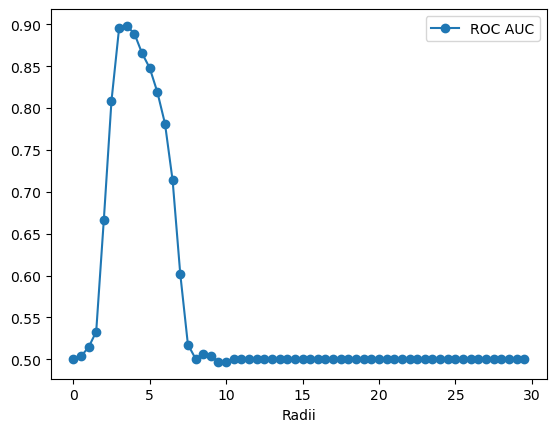

Best radius: 3.5


In [10]:
# ---------------------------------------------------------------------------- #
#                                 OPTIMIZATION                                 #
# ---------------------------------------------------------------------------- #

# Initiate CodeCarbon to track emissions
tracker = EmissionsTracker('RNC optimization', log_level='warning')
tracker.start()

# Optimize radii (cross validation)
radii = np.arange(0,30,.5)
roc_aucs = []

for rad in radii:
    # Create model
    temp_model = RadiusNeighborsClassifier(radius=rad, outlier_label=0)
    
    # Define pipeline depending on whether PCA is requested or not
    if PC_Features:
        steps = [
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=12)),
            ('RNC-classifier', temp_model)
        ]
    else:
        steps = [
            ('preprocessor', preprocessor),
            ('RNC-classifier', temp_model)
        ]
        
    pipeline = Pipeline(steps)
    roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=K_Folds)
    roc_aucs.append(np.mean(roc_auc))

plt.xlabel('Radii')
plt.plot(radii, roc_aucs, 'o-', label='ROC AUC')
plt.legend()
plt.show()

# Find best radius
best_radius = radii[np.argmax(roc_aucs)]

print(f'Best radius: {best_radius}')

# Save best trial parameters to a JSON file
params = {'radius': best_radius, 'outlier_label': 0}

with open('params/RNC-params.json', 'w') as f:
    json.dump(params, f)

In [11]:
# Create optimized model
model = RadiusNeighborsClassifier(**params)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('RNC-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('RNC-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], cv=K_Folds)

# Calculate and display results
acc = np.mean(cv_results['test_accuracy'])
acc_std = np.std(cv_results['test_accuracy'])
roc_auc = np.mean(cv_results['test_roc_auc'])
roc_auc_std = np.std(cv_results['test_roc_auc'])

print(f"Accuracy: {acc:.4f} ± {acc_std:.4f}")
print(f"AUC-ROC: {roc_auc:.4f} ± {roc_auc_std:.4f}")

# Stop emission tracking
_ = tracker.stop()

[codecarbon WARNING @ 10:25:17] Another instance of codecarbon is already running. Exiting.


Accuracy: 0.8078 ± 0.0528
AUC-ROC: 0.8981 ± 0.0440


In [12]:
# Save evaluation to an external file
file = 'scores.csv'

results = pd.DataFrame({
    'RNC-optimization': [acc, acc_std, roc_auc, roc_auc_std]
}, index = ['Accuracy', 'Accuracy STD', 'AUC-ROC', 'AUC-ROC STD'])

# Check if file exists
if os.path.exists(file):
    temp = pd.read_csv(file, index_col=0)
    results = pd.concat([temp, results], axis=1)

# Export
results.to_csv(file)

### References:

* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html